# imports

In [1]:
import datetime as dt

import mplfinance as mpf
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Отработка на логах торгов EURUSD

1. Get candles
2. Apply rules
3. Date cut
4. Create plots
5. Plot

In [2]:
def get_eurusd():
    eurusd = pd.read_csv('data/HistoricalPrices.csv',parse_dates=[0])
    eurusd.columns = ['date', 'open', 'high', 'low', 'close']
    eurusd = eurusd.iloc[::-1]
    eurusd = eurusd.set_index('date',drop=True)
    return eurusd

In [3]:
def rolling_min_max(df):
    df = df.copy()
    
    df['3_min'] = df['low'].rolling(3).min().shift(1)
    df['7_min'] = df['low'].rolling(7).min().shift(1)
    df['21_min'] = df['low'].rolling(21).min().shift(1)
    df['63_min'] = df['low'].rolling(63).min().shift(1)
    
    df['3_max'] = df['high'].rolling(3).max().shift(1)
    df['7_max'] = df['high'].rolling(7).max().shift(1)
    df['21_max'] = df['high'].rolling(21).max().shift(1)
    df['63_max'] = df['high'].rolling(63).max().shift(1)
    return df

In [4]:
def base_structure_actual(df):
    df = df.copy()
    base_min_init = df['low'].shift(4) < df['3_min']
    df['base_structure_min_actual'] = np.where(base_min_init,df['3_min'],np.nan)
    
    base_max_init = df['high'].shift(4) > df['3_max']
    df['base_structure_max_actual'] = np.where(base_max_init,df['3_max'],np.nan)
        
    return df

In [5]:
def base_structure_ffilled(df):
    df = df.copy()
    df['base_structure_min_filled'] = df['base_structure_min_actual'].fillna(method='ffill')
    
    df['base_structure_max_filled'] = df['base_structure_max_actual'].fillna(method='ffill')
    return df

In [6]:
def date_cut(df,start_date,end_date):
    return df[start_date:end_date]

In [7]:
def create_apdict(df,list_,cols):
    """
    В cols должен быть словарь:
    key = название столбца
    values = [markersize, alpha, color]
    
    """
    for key,values in cols.items():
        plot_ = mpf.make_addplot(df[key],
                                 type='scatter',
                                 markersize=values[0],
                                 alpha=values[1],
                                 color=values[2])
        list_.append(plot_)
#         print(key,values)
    return list_

# cols = {'base_structure_max_filled':[1,0.5,'aqua'],
#        'base_structure_min_filled':[1,0.5,'blue'],}

# test_ = create_apdict_base_structure(df,list_=[],cols=cols)
# display(test_)

In [8]:
def plot(df,apdict,figscale=3,type_='candle',style='default'):
    mpf.plot(df,type=type_,addplot=apdict,figscale=figscale,style=style)

In [54]:
def test():
    df = get_eurusd()
    df = rolling_min_max(df) # step 1
    df = base_structure_actual(df) # step 2
    df = base_structure_ffilled(df) # step 3
    df = base_structure_rule_1(df) # step 4

    start_date = '2021-01-01'
    end_date = '2021-02-28'

    df = date_cut(df,start_date=start_date,end_date=end_date)

    cols = {'base_structure_max_actual':[190,1,'aqua'],
           'base_structure_min_actual':[190,1,'blue'],
        'base_structure_max_filled':[80,0.5,'aqua'],
           'base_structure_min_filled':[80,0.5,'blue'],
           'base_structure_max':[20,1,'white'],
           'base_structure_min':[20,1,'white']
           }

    apdict = create_apdict(df,list_=[],cols=cols)

    plot(df,
         apdict=apdict,
         figscale=3,
         type_='candle',
         style='default')

In [49]:
#     И нужно сделать 2 правила:
#     1. Если нижняя базовая структура "проторгована", 
#     Т.е. лоу ниже базовой структуры или (эквивалентно)
#     она строилась по предыдущим значениям, 
#     а не в результате того началась/образовалась базовая структура по этой свечке
#     и второе условие: эта проторгованная базовая структура оказалась
#     выше верхней базовой структуры - 
#     то она не должна отрисовываться, т.е. там должны быть пропуски

#     df['base_structure_min'] = df.mask(((df['low'] < df['base_structure_min_filled'])&
#                                      (df['base_structure_min_filled'] > df['base_structure_max_filled'])),
#                                     np.nan,
#                                     df['base_structure_min_filled'])
    
#     df['base_structure_max'] = np.where(((df['high'] > df['base_structure_max_filled'])&
#                                      (df['base_structure_max_filled'] < df['base_structure_min_filled'])),
#                                     np.nan,
#                                     df['base_structure_max_filled'])

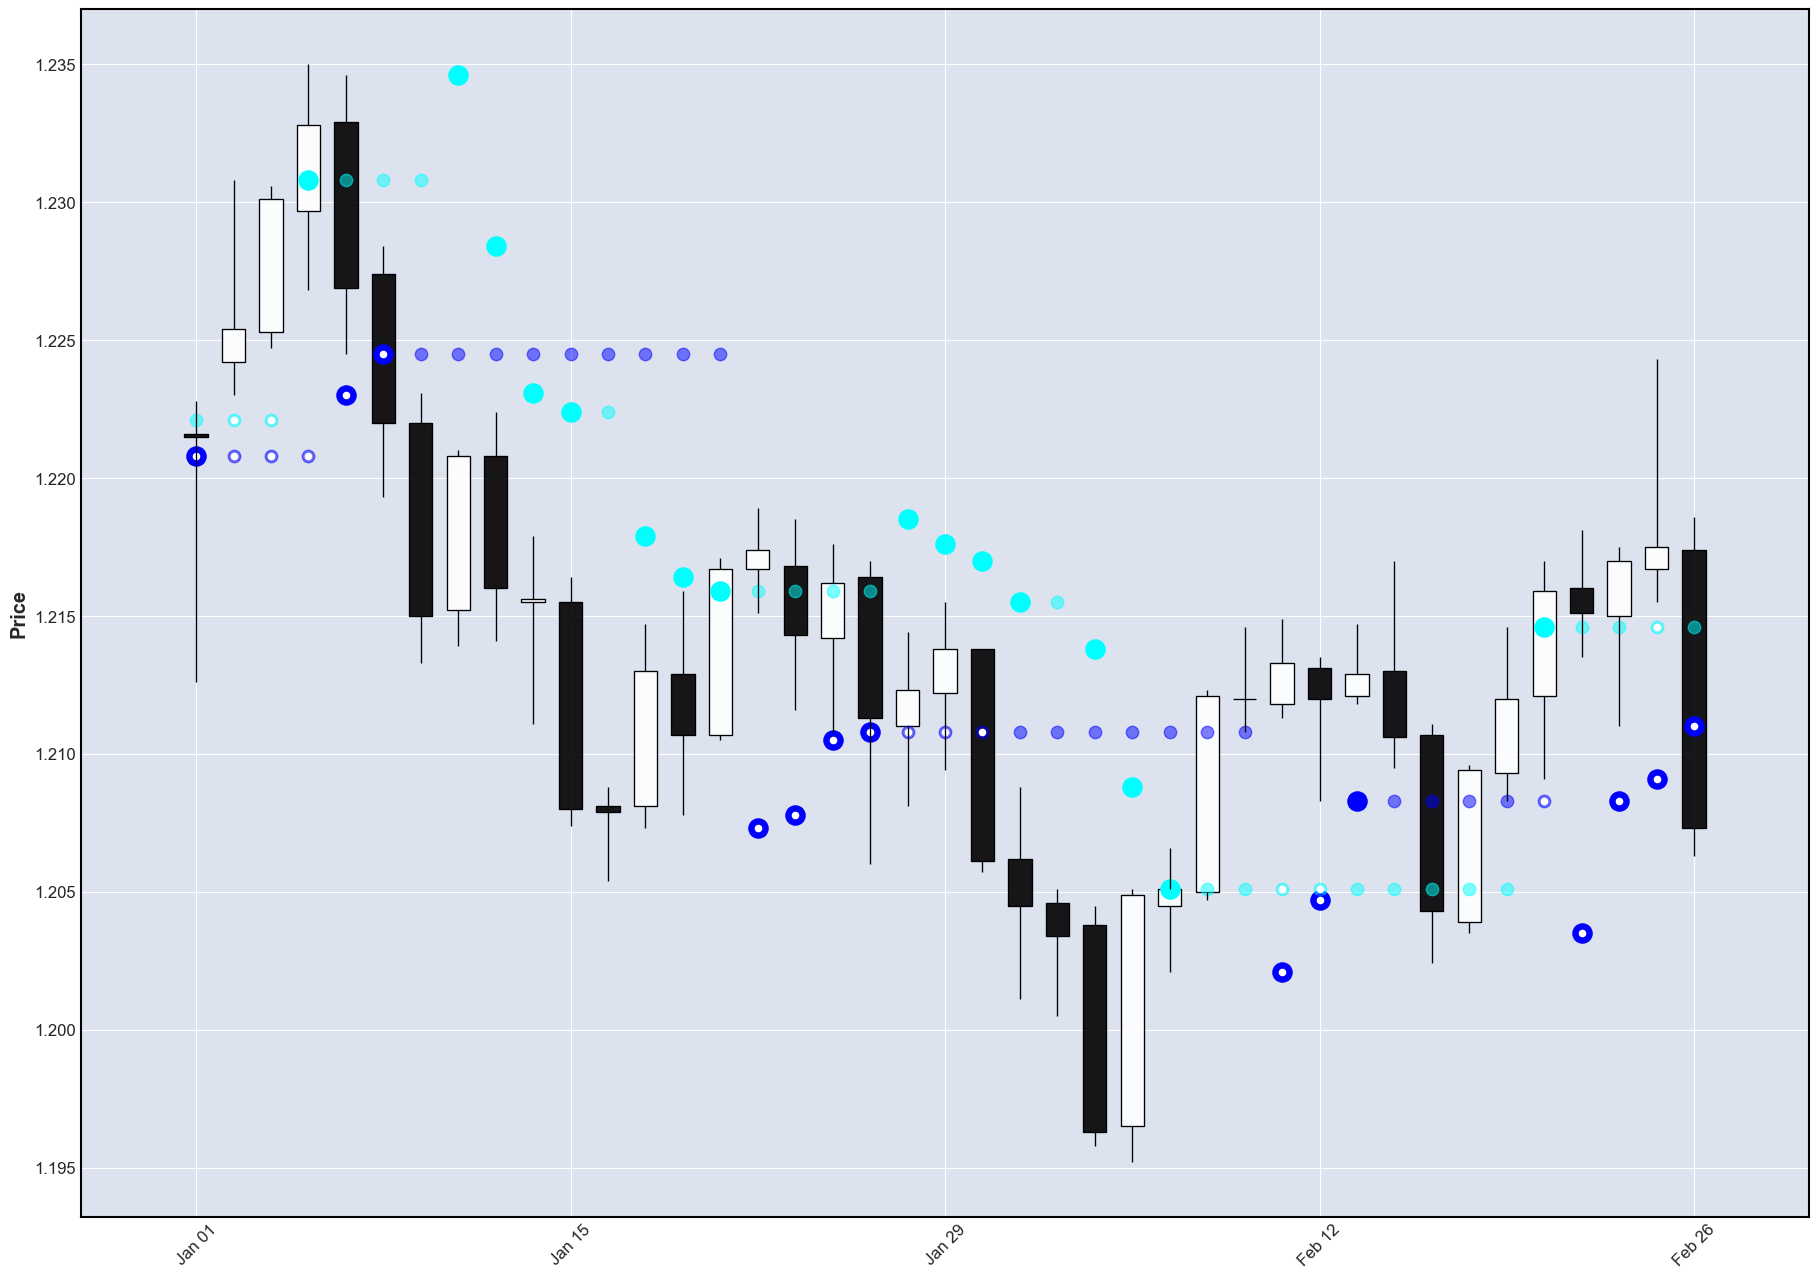

In [57]:
def base_structure_rule_1(df):
    df = df.copy()
# Мы используем base_structure_min_filled, где 
# low выше base_structure_min_filled и
# base_structure_max_filled выше base_structure_min_filled
    rule_1_min = df['high'] > df['base_structure_min_filled']
    rule_2_min = df['base_structure_max_filled'] > df['base_structure_min_filled']
    df['base_structure_min'] = df['base_structure_min_filled'].where(rule_1_min&rule_2_min,np.nan)
    
    rule_1_max = df['low'] > df['base_structure_max_filled']
    rule_2_max = df['base_structure_max_filled'] > df['base_structure_min_filled']
    df['base_structure_max'] = df['base_structure_max_filled'].where(rule_1_max&rule_2_max,np.nan)


    return df
test()

In [ ]:
alpha_1 = 0.5
alpha_2 = 1
alpha_3 = 1

ms_1 = 1
ms_2 = 2
ms_3 = 0.4

apdict = [
#           mpf.make_addplot(eurusd['63_max'],type='line',width=3*ms_1,alpha=alpha_1,color="red"),
#           mpf.make_addplot(eurusd['21_max'],type='line',width=2*ms_1,alpha=alpha_1,color="yellow"),
#           mpf.make_addplot(eurusd['7_max'],type='line',width=1*ms_1,alpha=alpha_1,color="green"),
#           mpf.make_addplot(eurusd['3_max'],type='line',width=.5*ms_1,alpha=alpha_1,color="blue"),
#           mpf.make_addplot(eurusd['3_min'],type='line',width=.5*ms_1,alpha=alpha_1,color="blue"),
#           mpf.make_addplot(eurusd['7_min'],type='line',width=1*ms_1,alpha=alpha_1,color="green"),
#           mpf.make_addplot(eurusd['21_min'],type='line',width=2*ms_1,alpha=alpha_1,color="yellow"),
#           mpf.make_addplot(eurusd['63_min'],type='line',width=3*ms_1,alpha=alpha_1,color="red"),
    
#           mpf.make_addplot(eurusd['global_structure_max'],type='line',width=3*ms_2,alpha=alpha_2,color="orange"),
#           mpf.make_addplot(eurusd['widescale_structure_max'],type='line',width=2*ms_2,alpha=alpha_2,color="yellow"),
#           mpf.make_addplot(eurusd['local_structure_max'],type='scatter',width=1*ms_2,alpha=alpha_2,color="lime"),
          mpf.make_addplot(df['base_structure_max_filled'],type='scatter',width=0.5*ms_2,alpha=alpha_2,color="aqua"),
          mpf.make_addplot(df['base_structure_min_filled'],type='scatter',width=0.5*ms_2,alpha=alpha_2,color="blue"),
#           mpf.make_addplot(eurusd['local_structure_min'],type='scatter',width=1*ms_2,alpha=alpha_2,color="green"),
#           mpf.make_addplot(eurusd['widescale_structure_min'],type='line',width=2*ms_2,alpha=alpha_2,color="yellow"),
#           mpf.make_addplot(eurusd['global_structure_min'],type='line',width=3*ms_2,alpha=alpha_2,color="orange"),
    
#           mpf.make_addplot(eurusd['h>=3max'],type='line',width=3*ms_3,alpha=alpha_3,color="blue"),
#           mpf.make_addplot(eurusd['l<=3min'],type='line',width=3*ms_3,alpha=alpha_3,color="blue"),
#           mpf.make_addplot(eurusd['l<=7min'],type='line',width=3*ms_3,alpha=alpha_3,color="green"),
#           mpf.make_addplot(eurusd['3min_3daysmax'],type='line',width=3*ms_3,alpha=alpha_3,color="black"),
            ]

### Подготовительные функции

In [ ]:
def get_eurusd_and_preprocess(func_):
    eurusd = pd.read_csv('data/HistoricalPrices.csv',parse_dates=[0])
    eurusd.columns = ['date', 'open', 'high', 'low', 'close']
#     eurusd.info()
    eurusd = eurusd.iloc[::-1]
    eurusd = func_(eurusd)
    eurusd = eurusd.set_index('date',drop=True)
    return eurusd

def plot(df,apdict,figscale=3,type='candle',style='default'):
    mpf.plot(df,type=type,addplot=apdict,figscale=figscale,style=style)
    
def date_cut(df,start_date,end_date):
    return df[start_date:end_date]

# Работаем здесь

In [ ]:
# ---------------------------
# ------------VER. 0.3-------
# ---------------------------
def struct_proto(df):
    df = df.copy()
    
    df['3_min'] = df['low'].rolling(3).min().shift(1)
    df['7_min'] = df['low'].rolling(7).min().shift(1)
    df['21_min'] = df['low'].rolling(21).min().shift(1)
    df['63_min'] = df['low'].rolling(63).min().shift(1)
    
    df['3_max'] = df['high'].rolling(3).max().shift(1)
    df['7_max'] = df['high'].rolling(7).max().shift(1)
    df['21_max'] = df['high'].rolling(21).max().shift(1)
    df['63_max'] = df['high'].rolling(63).max().shift(1)
    

#     df['base_structure_min_raw'] = np.where((df['low'].shift(4) < df['3_min']),df['3_min'],np.nan)
#     df['base_structure_min_raw'] = df['base_structure_min_raw'].fillna(method='ffill')
    
#     df['base_structure_max_raw'] = np.where((df['high'].shift(4) > df['3_max']),df['3_max'],np.nan)
#     df['base_structure_max_raw'] = df['base_structure_max_raw'].fillna(method='ffill')

#     df['base_structure_min'] = df['base_structure_min_raw']
#     df['base_structure_max'] = df['base_structure_max_raw']
    

    

    
# Base min
#     ОНО РАБОТАЕТ КАК НАДО
    
#     Здесь мы находим/начинаем нижнюю базовую структуру.
#     Если минимум 4-ой свечки 
#     (счет идет с конца, т.е. 4,3,2,1,0, 0 - это текущая свечка, по которой расчитываем)
#     ниже минимумов 3,2,1, то структура в этой рассчитываемой свечке есть.
# 
    base_min_init = df['low'].shift(4) < df['3_min']

#    Если структура в рассчитываемой свечке есть, то обозначаем ее, как минимум последних трех дней
#    т.е. минимальный минимум 3,2,1 свечей. (Рассчитываем по 0 свечке)
#    Если структуры нет, то оставляем пропуск

    df['base_structure_min_actual'] = np.mask(base_min_init,df['3_min'],np.nan) # GOOD! 
    
#     Дальше нам необходимо сделать так, чтобы вместо пропусков было последнее значение структуры
#     т.е. вообразим, что смотрим на свечки 5,4,3,2,1,0
#         543210
#         543210
#         543210
#         54 210
#         5   1
#     Для 0 не существует нижней базовой структуры, потому что какой-то из минимумов 3,2,1 свечек (минимум 1-ой свечки)
#     Ниже минимума 4 свечи
#     Но для свечки номер 1 - нижняя базовая структура существует,
#     Потому что минимумы 4,3,2 выше минимума 5 свечи
#     Нам нужно под свечкой 0, поставить ту же самую границу нижней базовой структуры, что была под 1.

#     Для этого нам нужно просто заполнить наны методом 'ffill' (заполняет пропуски последним значением)

    df['base_structure_min_filled'] = df['base_structure_min_actual'].fillna(method='ffill')
    
    
#    Повторим для верхней базовой структуры
    base_max_init = df['high'].shift(4) > df['3_max']
    df['base_structure_max_actual'] = np.mask(base_max_init,df['3_max'],np.nan)
    df['base_structure_max_filled'] = df['base_structure_max_actual'].fillna(method='ffill')

#     Можно это записать в 2 строки:
#     df['base_structure_min_raw'] = np.where((df['low'].shift(4) < df['3_min']),df['3_min'],np.nan)
#     df['base_structure_min_raw'] = df['base_structure_min_raw'].fillna(method='ffill')

#     Дальше мы строим такую же структуру с противоположной стороны
#     df['base_structure_max_raw'] = np.where((df['high'].shift(4) > df['3_max']),df['3_max'],np.nan)
#     df['base_structure_max_raw'] = df['base_structure_max_raw'].fillna(method='ffill')


# Тут работаем <<<<<<<<<<<<<<<<<
# ----------------------------------------
# ------------------------------
#     И нужно сделать 2 правила:
#     1. Если нижняя базовая структура "проторгована", 
#     Т.е. лоу ниже базовой структуры или (эквивалентно)
#     она строилась по предыдущим значениям, 
#     а не в результате того началась/образовалась базовая структура по этой свечке
#     и второе условие: эта проторгованная базовая структура оказалась
#     выше верхней базовой структуры - 
#     то она не должна отрисовываться, т.е. там должны быть пропуски
    df['base_structure_min'] = np.mask(((df['low'] < df['base_structure_min_filled'])&
                                         (df['base_structure_min_filled'] > df['base_structure_max_filled'])),
                                        np.nan,
                                        df['base_structure_min_filled'])
#     df['base_structure_min'] = np.where(((df['base_structure_min_filled'] > df['base_structure_max_filled'])
#                                          &~base_min_init),
#                                         np.nan,
#                                         df['base_structure_min_filled'])
#     И наоборот:
#     2. Если верхняя структура ниже верхней, то верхняя не должна отрисовываться, т.е. там должен быть пропуск
    df['base_structure_max'] = np.mask(((df['high'] > df['base_structure_max_filled'])&
                                         (df['base_structure_max_filled'] < df['base_structure_min_filled'])),
                                        np.nan,
                                        df['base_structure_max_filled'])
#     df['base_structure_max'] = np.where(((df['base_structure_max_filled'] < df['base_structure_min_filled'])
#                                          &~base_max_init),
#                                         np.nan,
#                                         df['base_structure_max_filled'])
    
    
#     df['']



# LOCAL STRUCTURE
# TEMP
    df['local_structure_min_raw'] = np.mask((df['low'].shift(8) < df['7_min']),df['7_min'],np.nan)
    df['local_structure_min_raw'] = df['local_structure_min_raw'].fillna(method='ffill')
    
    df['local_structure_max_raw'] = np.mask((df['high'].shift(8) > df['7_max']),df['7_max'],np.nan)
    df['local_structure_max_raw'] = df['local_structure_max_raw'].fillna(method='ffill')   
    
    df['local_structure_min'] = df['local_structure_min_raw']
    df['local_structure_max'] = df['local_structure_max_raw']

    return df

eurusd = get_eurusd_and_preprocess(func_=struct_proto)

start_date = '2021-01-01'
end_date = '2021-02-28'

# start_date = '2021-01-02'
# end_date = '2021-01-31'

# start_date = '2021-01-25'
# end_date = '2021-01-29'


eurusd = date_cut(eurusd,start_date=start_date,end_date=end_date)
cols = ['high','low','63_min','widescale_structure_max','price<wsmax','grouper','glob_min']
# eurusd[cols]
# display(
#         eurusd.drop(columns=['open','close','63_min','63_max','7_max','21_max','high','21_min'])
#         )

alpha_1 = 0.5
alpha_2 = 1
alpha_3 = 1

ms_1 = 1
ms_2 = 2
ms_3 = 0.4



apdict = [
#           mpf.make_addplot(eurusd['63_max'],type='line',width=3*ms_1,alpha=alpha_1,color="red"),
#           mpf.make_addplot(eurusd['21_max'],type='line',width=2*ms_1,alpha=alpha_1,color="yellow"),
#           mpf.make_addplot(eurusd['7_max'],type='line',width=1*ms_1,alpha=alpha_1,color="green"),
#           mpf.make_addplot(eurusd['3_max'],type='line',width=.5*ms_1,alpha=alpha_1,color="blue"),
#           mpf.make_addplot(eurusd['3_min'],type='line',width=.5*ms_1,alpha=alpha_1,color="blue"),
#           mpf.make_addplot(eurusd['7_min'],type='line',width=1*ms_1,alpha=alpha_1,color="green"),
#           mpf.make_addplot(eurusd['21_min'],type='line',width=2*ms_1,alpha=alpha_1,color="yellow"),
#           mpf.make_addplot(eurusd['63_min'],type='line',width=3*ms_1,alpha=alpha_1,color="red"),
    
#           mpf.make_addplot(eurusd['global_structure_max'],type='line',width=3*ms_2,alpha=alpha_2,color="orange"),
#           mpf.make_addplot(eurusd['widescale_structure_max'],type='line',width=2*ms_2,alpha=alpha_2,color="yellow"),
#           mpf.make_addplot(eurusd['local_structure_max'],type='scatter',width=1*ms_2,alpha=alpha_2,color="lime"),
          mpf.make_addplot(eurusd['base_structure_max'],type='scatter',width=0.5*ms_2,alpha=alpha_2,color="aqua"),
          mpf.make_addplot(eurusd['base_structure_min'],type='scatter',width=0.5*ms_2,alpha=alpha_2,color="blue"),
#           mpf.make_addplot(eurusd['local_structure_min'],type='scatter',width=1*ms_2,alpha=alpha_2,color="green"),
#           mpf.make_addplot(eurusd['widescale_structure_min'],type='line',width=2*ms_2,alpha=alpha_2,color="yellow"),
#           mpf.make_addplot(eurusd['global_structure_min'],type='line',width=3*ms_2,alpha=alpha_2,color="orange"),
    
#           mpf.make_addplot(eurusd['h>=3max'],type='line',width=3*ms_3,alpha=alpha_3,color="blue"),
#           mpf.make_addplot(eurusd['l<=3min'],type='line',width=3*ms_3,alpha=alpha_3,color="blue"),
#           mpf.make_addplot(eurusd['l<=7min'],type='line',width=3*ms_3,alpha=alpha_3,color="green"),
#           mpf.make_addplot(eurusd['3min_3daysmax'],type='line',width=3*ms_3,alpha=alpha_3,color="black"),
            ]


plot(eurusd,
     apdict=apdict,
     figscale=3,
     type='candle',
     style='default')

# Очень полезные штуки

In [ ]:
# ----------------------------------------
# Очень крутой прием
# ----------------------------------------


def struct_dummie(df):
    df = df.copy()
    df['63_min'] = df['low'].rolling(63).min().shift(1)
    df['21_max'] = df['high'].rolling(21).max().shift(1)
    df['63_max'] = df['high'].rolling(63).max().shift(1)
    
    rolling_21max = df['21_max'].rolling(21).min().shift(1)
    mask_21_max = (df['high']>df['21_max']).rolling(21).max() == 1
    r21max_eq_r63max = df['21_max'] != df['63_max']
    df['widescale_structure_max'] = np.where(((mask_21_max)&(r21max_eq_r63max)),
                                                rolling_21max,
                                                df['21_max'])

    df['ws_max_touch'] = np.where(df['high'] >= df['widescale_structure_max'],1,0)
    return df

eurusd = get_eurusd_and_preprocess(func_=struct_dummie)

start_date = '2021-04-14'
end_date = '2021-06-20'

eurusd = date_cut(eurusd,start_date=start_date,end_date=end_date)
test = eurusd[['ws_max_touch','count_zeros']]


# https://stackoverflow.com/questions/29421356/pandas-cumulative-sum-on-column-with-condition

# Берем столбец с по сути булевыми значениями было ли касание цены верхней масштабной структуры
# Если было касание то 1, если не было то 0
# Но нам надо посчитать сколько прошло строк после последнего касания, т.е. считать сколько не было касаний подряд
# Поэтому меняем 1 на 0 и 0 на 1, чтобы проще было считать 1

# df['ws_max_touch'] = np.where(df['high'] >= df['widescale_structure_max'],1,0)

test['ws_max_touch'] = test['ws_max_touch'].replace({0:1,1:0})

# Здесь просто убираем пропуски
v = test['ws_max_touch'].dropna()
# display(v)

# Это группировщик. 
# Он понадобится для дальнейшего груп бай
# Он создает столбец с булевыми значениями, которые говорят равно ли предыдущее значение текущему
grouper_init = (v!=v.shift())


# А затем считает кумулятивную сумму того, что получилось
# Поскольку True это единица,
# То к кумулятивной сумме будет прибавляться единица, каждый раз
# Когда v!=v.shift(), т.е. когда текущее значение не равно предыдущему
# Т.е. давая начало новой группе.
# Получается 1 значение обязательно True - кумулятивная сумма 1 - обозначает первую группу
# Затем кумулятивная сумма остается равна 1 пока какое-то значение перестанет быть равно предыдущему
# там возникает True, а значит кумулятивная сумма увеличивается на 1 и становится равна 2
# Так же ровно до того момента пока какое-то значение перестанет быть равно предыдущему
# Так выстраиваются группы
grouper = (v!=v.shift()).cumsum()


display(pd.concat([grouper_init,grouper],axis=1).head())

test['grouper_init'] = grouper_init
test['grouper'] = grouper

# Затем используем этот группировщик в групбай искомого столбца и применяем cumsum()


test['another'] = test.groupby(grouper)['ws_max_touch'].cumsum()

test